# Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
import pandas as pd
import os
import shutil
import cv2
import tqdm
import math

In [2]:
OUTPUT_DATA_DIR = "Dataset/"
GLO_DIR = "GLO/"
DEP_DIR = "3DEP/"
DEP_NODATA = -1000000000.0
WSF_DIR = "WSF/"
OSM_DIR = "OSM/"
GLO_INTERP_DIR = "GLO_INTERP/"
GLO_REMOVED_BUILDINGS = "GLO_REMOVED_BUILDINGS/"

## Functions

In [ ]:
def read_map(path):
    tmp = tiff.imread(path)
    return np.array(tmp)

In [3]:
radius = 3
kernel = np.zeros_like(np.float32, shape = [2 * radius + 1, 2 * radius + 1 ])
for i in range(2 * radius + 1):
  for j in range(2 * radius + 1):
    value = math.sqrt((i - radius) * (i - radius) + (j - radius) * (j - radius))
    if value > radius or (i == radius and j == radius):
      continue
    kernel[i, j] = 1/value

In [4]:
class ZeroKernelSum(Exception):
    pass

def interpolate(x, y, array, kernel):
  array_shape = array.shape
  kernel_shape = kernel.shape
  radius = int (kernel_shape[0] / 2 )
  kernel_copy = kernel

  for i in range(kernel_shape[0]):
    if i + x - radius < 0 or i + x - radius > array_shape[0] - 1:
      kernel_copy[i, :] = 0
      continue
    for j in range(kernel_shape[0]):
      if j + y - radius < 0 or j + y - radius > array_shape[1] - 1:
        kernel_copy[i, j] = 0
        continue
      if np.isnan(array[i + x - radius, j + y - radius]):
        kernel_copy[i, j] = 0
        continue
  #print(kernel_copy)
  if kernel_copy.sum() == 0:
    raise ZeroKernelSum("Kernel sum zero")

  kernel_copy /= kernel_copy.sum()

  result = 0
  for i in range(kernel_shape[0]):
    for j in range(kernel_shape[0]):
      if kernel_copy[i, j] == 0:
        continue
      result += kernel_copy[i,j] * array[i + x - radius, j + y - radius]

  return result

In [5]:
def interpolate_map(map):
  result = np.copy(map)
  x,y = result.shape
  while np.isnan(result).any():
    for i in range(x):
      for j in range(y):
        if not np.isnan(result[i,j]):
          continue
        try:
          result[i,j] = interpolate(i, j, result, np.copy(kernel))
        except ZeroKernelSum:
          pass
  
  return result

In [6]:
def filter_with_mask(map, mask, threashhold = 0.00001, nodata = 0):
    x,y = map.shape
    z = int(mask.shape[0] / map.shape[0])
    threshhold = threashhold*z*z

    filtered_array = np.copy(map)
    
    for i in range(x):
        for j in range(y):
            numOfBuildingPixel = 0
            for i_mask in range(z):
                for j_mask in range(z):
                    if mask[i_mask + i * z][j_mask + j * z] != nodata:
                        numOfBuildingPixel += 1
            if numOfBuildingPixel >= threshhold:
                filtered_array[i][j] = float('nan')
                    
    return filtered_array

In [7]:
CHECK_OFFSETS = [(-1,-1), (-1, 0), (-1, 1),
                 (0, -1),          (0, 1),
                 (1,-1),  (1, 0),  (1, 1)]

def get_buidlings_heights(glo, buildings, num = 10000, nodata = 0, height_quantile = 0.85):
    visited = np.where(buildings == nodata, True, False)
    buildings_heights = np.zeros(visited.shape)
    size_x, size_y = buildings.shape
    for x in range(size_x):
        for y in range(size_y):
            if not visited[x][y]:
                heights = []
                building_coordinates = []
                points_to_go = [(x,y)]
                
                while len(points_to_go) != 0:
                    i, j = points_to_go.pop()
                    visited[i][j] = True
                    heights.append(glo[int(i/9)][int(j/9)])
                    building_coordinates.append((i,j))
                    
                    for x_offset, y_offset in CHECK_OFFSETS:
                        i_offsetted = i + x_offset
                        j_offsetted = j + y_offset
                        if 0 <= i_offsetted < size_x and 0 <= j_offsetted < size_y:
                            if not visited[i_offsetted, j_offsetted]:
                                delta_height = buildings[i, j] - buildings[i_offsetted, j_offsetted]
                                if abs(delta_height) < 1:
                                    points_to_go.append((i_offsetted, j_offsetted))
                num -= 1
                if num != 0:
                   #continue
                   pass
                        
                height = np.quantile(heights, height_quantile)
                #print(height)
                #print(np.sort(heights))                
               
                for i, j in building_coordinates:
                    buildings_heights[i][j] = height
                    
                if num == 0:
                    return buildings_heights
                
                
    return buildings_heights

In [57]:
dataset = {}

# Testing on Dataset

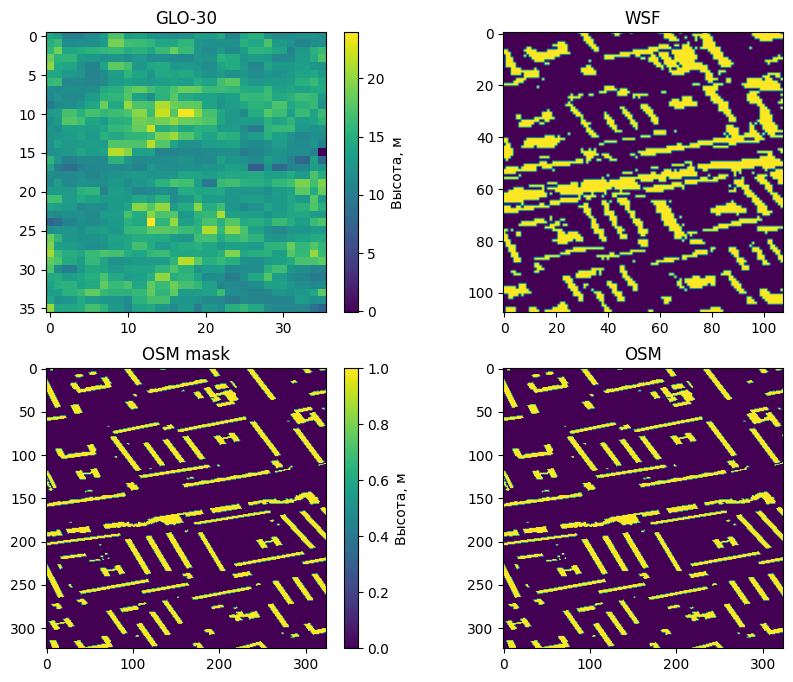

In [8]:
def get_file_with_suffix(dir, suffix):
    filelist=os.listdir(dir)
    for file in filelist:
        file_parts = file.split("_")
        if len(file_parts) < 3:
            continue
        
        file_suffix = file_parts[-2]+ "_" + file_parts[-1]
        if file_suffix == suffix:
            return file

# суффикс интересующего файла
suffix = "015_038.tif"
#suffix = "013_037.tif"
#suffix = "006_030.tif"

glo = read_map(OUTPUT_DATA_DIR+GLO_DIR + get_file_with_suffix(OUTPUT_DATA_DIR+GLO_DIR, suffix))
wsf = read_map(OUTPUT_DATA_DIR+WSF_DIR + get_file_with_suffix(OUTPUT_DATA_DIR+WSF_DIR, suffix))
osm = read_map(OUTPUT_DATA_DIR+OSM_DIR + get_file_with_suffix(OUTPUT_DATA_DIR+OSM_DIR, suffix))

fig, ax = plt.subplots(figsize=(10, 8))
ax.remove()
ax = plt.subplot(2, 2, 1)
plt.imshow(glo)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.title("GLO-30")
plt.subplot(2, 2, 2)
plt.imshow(wsf)
plt.title("WSF")
plt.subplot(2, 2, 4)
plt.imshow(osm)
plt.title("OSM")
ax = plt.subplot(2, 2, 3)
plt.imshow(np.where(osm == -1, False, True))
plt.title("OSM mask")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

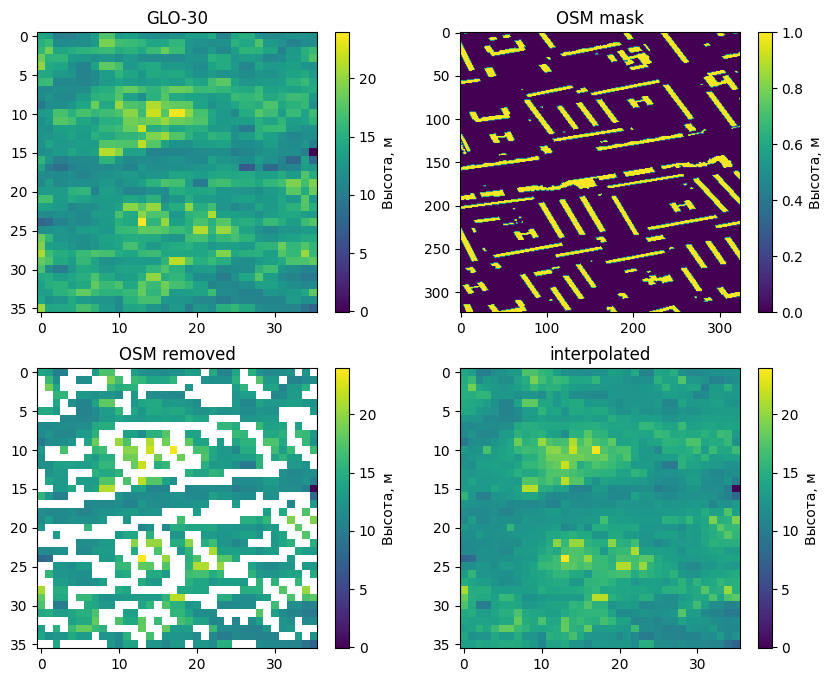

In [10]:
glo_filter_osm = filter_with_mask(glo, osm, 0.1, -1)
glo_interp_osm = interpolate_map(glo_filter_osm)
glo_scaled_osm = cv2.resize(glo_interp_osm, dsize=np.multiply(glo_interp_osm.shape, 3), interpolation=cv2.INTER_CUBIC)

fig, ax = plt.subplots(figsize=(10, 8))
ax.remove()
ax = plt.subplot(2, 2, 1)
plt.imshow(glo)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.title("GLO-30")
ax = plt.subplot(2, 2, 2)
plt.imshow(np.where(osm == -1, False, True))
plt.title("OSM mask")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 3)
plt.imshow(glo_filter_osm)
plt.title("OSM removed")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 4)
plt.imshow(glo_interp_osm)
plt.title("interpolated")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

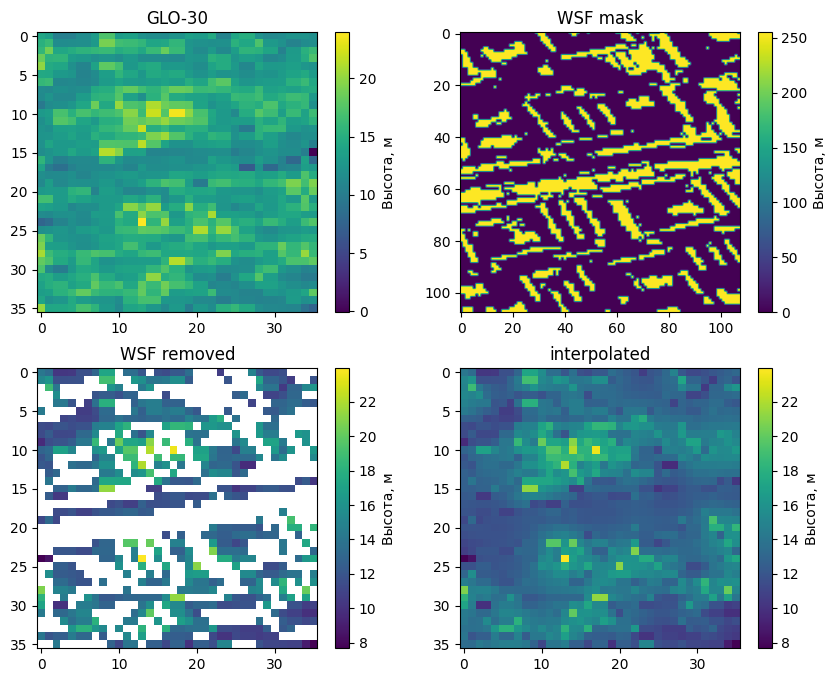

In [11]:
glo_filter_wsf = filter_with_mask(glo, wsf, 0.2)
glo_interp_wsf = interpolate_map(glo_filter_wsf)
glo_scaled_wsf = cv2.resize(glo_interp_wsf, dsize=np.multiply(glo_interp_wsf.shape, 3), interpolation=cv2.INTER_CUBIC)

fig, ax = plt.subplots(figsize=(10, 8))
ax.remove()
ax = plt.subplot(2, 2, 1)
plt.imshow(glo)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.title("GLO-30")
ax = plt.subplot(2, 2, 2)
plt.imshow(wsf)
plt.title("WSF mask")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 3)
plt.imshow(glo_filter_wsf)
plt.title("WSF removed")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 4)
plt.imshow(glo_interp_wsf)
plt.title("interpolated")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

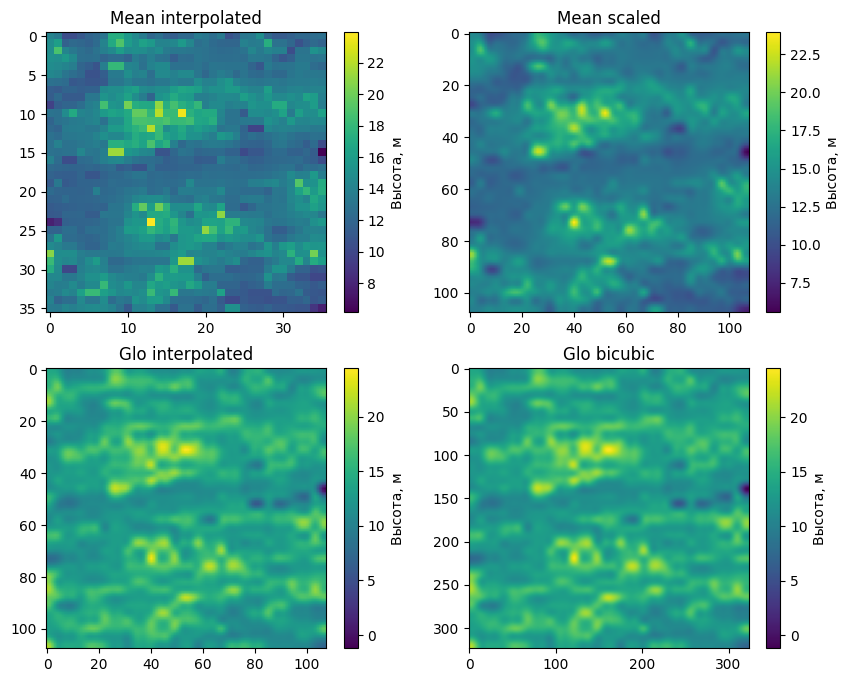

In [12]:
mean_interp = (glo_interp_osm + glo_interp_wsf)/2
mean_scaled = (glo_scaled_osm + glo_scaled_wsf)/2

fig, ax = plt.subplots(figsize=(10, 8))
ax.remove()
ax = plt.subplot(2, 2, 1)
plt.imshow(mean_interp)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.title("Mean interpolated")
ax = plt.subplot(2, 2, 2)
plt.imshow(mean_scaled)
plt.title("Mean scaled")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 3)
plt.imshow(cv2.resize(glo, dsize=(108,108), interpolation=cv2.INTER_CUBIC))
plt.title("Glo interpolated")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
ax = plt.subplot(2, 2, 4)
plt.imshow(cv2.resize(glo, dsize=(324,324), interpolation=cv2.INTER_CUBIC))
plt.title("Glo bicubic")
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

tiff.imwrite(OUTPUT_DATA_DIR + "TestOSMRemoved.tif", mean_interp)
tiff.imwrite(OUTPUT_DATA_DIR + "TestOSMRemovedScaled.tif", mean_scaled)
tiff.imwrite(OUTPUT_DATA_DIR + "TestGLOBicubic.tif", cv2.resize(glo, dsize=(324,324), interpolation=cv2.INTER_CUBIC))
tiff.imwrite(OUTPUT_DATA_DIR + "TestGLOInterp.tif", cv2.resize(glo, dsize=(108,108), interpolation=cv2.INTER_CUBIC))

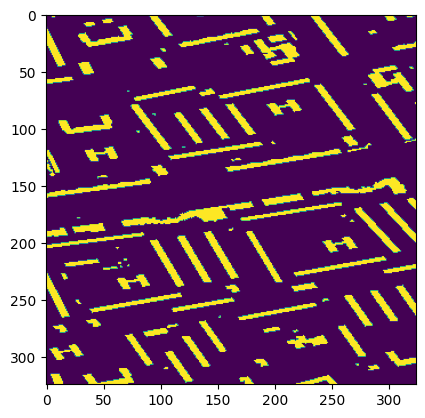

In [9]:
plt.imshow(osm)

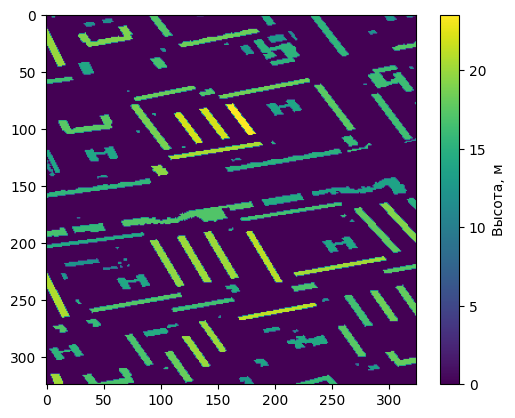

In [12]:
buildings_heights = get_buidlings_heights(glo, osm, nodata=-1, height_quantile=1)
fig, ax = plt.subplots()
plt.imshow(buildings_heights)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')

(324, 324)


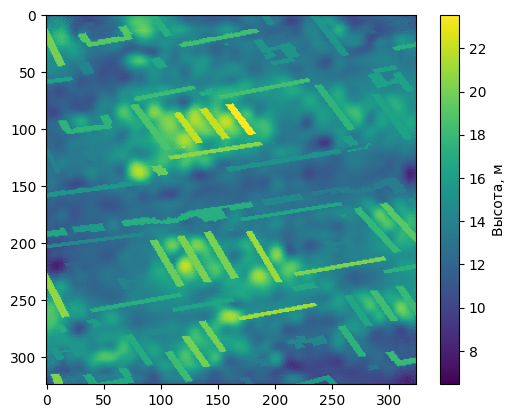

In [14]:
predicted_no_buildings = read_map(OUTPUT_DATA_DIR + "TestPredictedNoBuildings.tif")

x,y = buildings_heights.shape
map = np.copy(predicted_no_buildings)
for i in range(x):
    for j in range(y):
        if map[i][j] < buildings_heights[i][j]:
            map[i][j] = buildings_heights[i][j]

print(map.shape)

fig, ax = plt.subplots()
plt.imshow(map)
im = ax.get_images()[0]
cb = fig.colorbar(im, ax=ax)
cb.set_label('Высота, м')
plt.show()

tiff.imwrite(OUTPUT_DATA_DIR + "TestResult.tif", map)